# Example predictions of field particle correlation signatures
Here, we predict the signatures found in Howes 2017 (a kinetic alfven wave experiencing landau damping) as an example and generate relevant dispersion relations plots. 

Please, open a terminal, navigate to the install directory, make PLUME (run 'make all'), and run all the cells in this notebook to verify that everything is working correctly.

This notebook and related libraries serve as wrappers that make and call input files for plume by calling commands like "os.system('./plume.e *flnm*.in >> outlog' ". One can also use ./plume.e *flnm*.in to run plume. The library that is called used lfpc.*funcname*(*args*) involves making inputs and calling plume. The library that is called using commands like lp.*funcname*(*args*) involves making plots.

You will need to be able to call a bash terminal when commands like os.system('*command*') is called in the library. This is the default behavior for most installs of jupyter notebook on MacOs, and likely for linux too. Windows will likely need additional setup...

The plot library is meant to serve as an example for users to modify as it is not complete.

If things are not behaving as expected, please check the outlog, where all plume output is saved when using this notebook.

*** Please check outlog for any warnings that PLUME might create and write to the outlog. These warnings *will not* be presented here in any way. Using this notebook, one may input parameters that allows the solver to run, but violates assumptions made when deriving the equations used by the solver ***

Note: Here, we make a class 'plumeinput' that contains input parameters which are accumulated throughout this notebook. Please be sure to run all above inputs containing 'plumeinput.*command*(*arguments*)', before making any 'lfpc.*function*(*arguments*)' call, as the wrapper class may need prior parameters.

Warning: these scripts only support using two species currently (Nov 9 2023)

## Load libraries, and enter parameters

In [1]:
import linfpclib.linfpc as lfpc
import linfpclib.linfpcplot as lp

import os
import numpy as np

In [2]:
#if a change is made to the above libraries, one can either restart the notebook, 
#  or call these functions to load changes in library
import importlib
importlib.reload(lfpc)
importlib.reload(lp)

<module 'linfpclib.linfpcplot' from '/Users/work/Documents/Research/LinKinTheory/LinFPCPaperAndData/PLUME/linfpclib/linfpcplot.py'>

In [3]:
filetag = 'howes2017' #this will be used to name all output files and folders
plumeinput = lfpc.plume_input(filetag)

In [4]:
betap=1
kperp=1.3
kpar=.05 #not specified in paper but when kpar << 1, exact number is not needed as dynamics don't change much in this regime
vtp=1.0E-4
nspec=2
nscan=1
option=1
nroot_max=20
use_map=True
writeOut=True

plumeinput.set_params(betap,kperp,kpar,vtp,nspec,nscan,option,\
                    nroot_max,use_map,writeOut)

In [5]:
#make ions
tauS=1.0
muS=1.0
alphS=1.0
Qs=1.0
Ds=1.0
vvS=0.
plumeinput.make_species(tauS, muS, alphS, Qs, Ds, vvS, spec_n = 1) #be sure to specify species number

No species found, creating first species...


In [6]:
#make elecs
tauS=1
muS=1836
alphS=1.0
Qs=-1.0
Ds=1.0
vvS=0.
plumeinput.make_species(tauS, muS, alphS, Qs, Ds, vvS, spec_n = 2)

Appending species to list. Total species is now  2


In [7]:
#given the fixed above parameters, PLUME solves the dispersion relation for values over the range of omega
#and gamma given below. It initializes a grid (either log spaced or evenly spaced) and does it's best to find 
#all roots in this range. For each grid point, gradient descent is used to try and find a nearby solution.
#Sometimes this results in no found root. Sometimes roots are found outside the sweep range 
#(both close to the range, and very far from it)
loggridw=False
omi=-1.0E-02
omf=1.0E-0
gami=-2.0E-01
gamf=2.0E-01
positive_roots=True
plumeinput.set_maps(loggridw,omi,omf,gami,gamf,positive_roots)

In [8]:
inputfldr= 'input/'+filetag+'/' #folder where all generated input files will be placed
cmd = 'mkdir '+inputfldr
print(cmd)
os.system(cmd) #256 exit code means folder already exits (no need to worry), 0 means it sucessfully made the folder

mkdir input/howes2017/


mkdir: input/howes2017/: File exists


256

## Find roots

In [9]:
importlib.reload(lp)
roots = lfpc.compute_roots(plumeinput,inputfldr+'roots',filetag)

OVERWRITING OPTION; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
mkdir data/howes2017
./plume.e input/howes2017/roots.in >> outlog


mkdir: data/howes2017: File exists


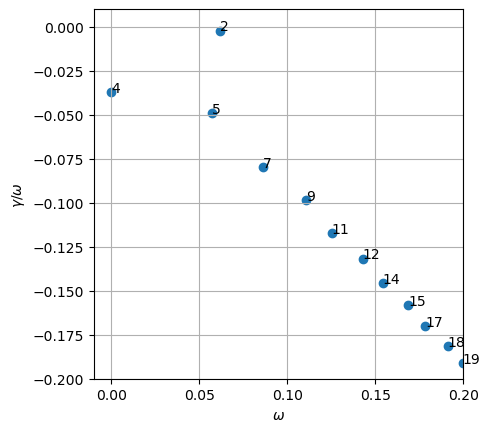

In [10]:
flnm = 'figures/'+filetag+'/'+filetag+'roots.png'
lp.plot_roots(roots,flnm=flnm,xlim=[-0.01,.2],ylim=[-.2,0.01])

## Select root to compute dispersion relation as a function of selected variable and predict damping contribution by mechanisms 
The following block of code will plot the dispersion relation for the root at index 2

In [11]:
rootidx = 2
roots[rootidx] #later we show that this is the alfven root

(0.061719-0.0022112j)

In [12]:
importlib.reload(lfpc)
sweepvarkey = 'kperp' #change this value to sweep over other variables
                      #wrapper currently supports kperp, kpar, betap, and vtp sweeps
                      #see readme for all available sweep options
stylenum = 0
sweepmin = .1
sweepmax = 100
root = roots[rootidx]
inputflnm = inputfldr+'sweep'
outputname = 'sweep'
sweep = lfpc.make_sweeps_that_branch_from_params(plumeinput,stylenum,sweepvarkey,sweepmin,sweepmax,root,inputflnm,outputname,outlog='outlog',nsamps=50)

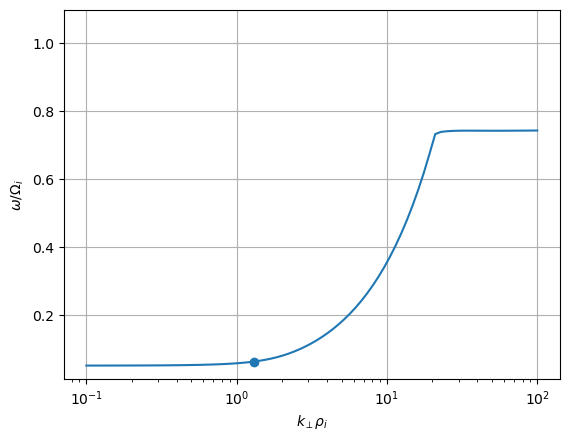

In [13]:
xkey = 'kperp'
ykey = 'w'
xlabel = r"$k_\perp \rho_i$"
ylabel = r"$\omega / \Omega_i$"
ylim = [0.01,1.1]
xlim = []
root = roots[rootidx]

plot_root = True #will plot scatter point x,y = sweep[xkey],sweep['w'] for value at input kperp,kpar,omega. This is the origin of the sweep

flnm = 'figures/'+filetag+'/'+filetag+'disprelkperpw.png'
lp.plot_disp_rel(plumeinput, root, sweep, xkey, ykey, xlabel, ylabel, flnm = flnm, plot_root = plot_root, xlim = xlim, ylim = ylim)

In [14]:
#other keys that can be plotted as a function of sweepvarkey
print(sweep.keys())

dict_keys(['kperp', 'kpar', 'betap', 'vtp', 'w', 'g', 'bxr', 'bxi', 'byr', 'byi', 'bzr', 'bzi', 'exr', 'exi', 'eyr', 'eyi', 'ezr', 'ezi', 'ux1r', 'ux1i', 'uy1r', 'uy1i', 'uz1r', 'uz1i', 'ux2r', 'ux2i', 'uy2r', 'uy2i', 'uz2r', 'uz2i', 'n1r', 'n1i', 'n2r', 'n2i', 'ps1', 'ps2', 'p1ttd1', 'p1ttd2', 'p1ld1', 'p1ld2', 'p1n0', 'p1cd', 'p2ld1', 'p2ld2', 'p2ttd1', 'p2ttd2', 'p2n0', 'p2cd', 'p1tau', 'p1mu', 'p1alph', 'p1q', 'p1D', 'p1vv', 'p2tau', 'p2mu', 'p2alph', 'p2q', 'p2D', 'p2vv'])


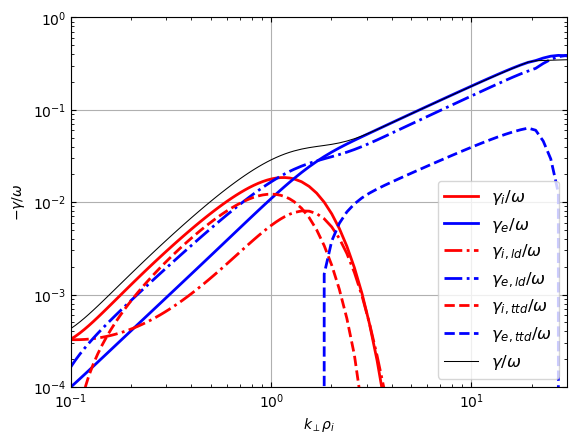

In [15]:
#plot power rate due to different mechanisms/ susc tensor 'splits' 
#INTO the particles in units of gamma/omega (that is gamma/omega = -1 indicates that particles are gaining energy)

xlim = [0.1,30]
ylim = [0.0001,1]
importlib.reload(lfpc)
importlib.reload(lp)

flnm = 'figures/'+filetag+'/'+filetag+'disprelpowers.png'
lp.plot_disp_power(sweep,flnm=flnm,xlim=xlim,ylim=ylim)

In [16]:
#sweep over species parameters too
sweepvarkey = 'tauS' #change this variable to sweep over other variables
                      #wrapper currently supports kperp, kpar, betap, and vtp sweeps
                      #see readme for all available sweep options
stylenum = 2 #2 to change second species tauS
sweepmin = .1
sweepmax = 100
root = roots[rootidx]
inputflnm = inputfldr+'sweep'
outputname = 'sweep'
sweep = lfpc.make_sweeps_that_branch_from_params(plumeinput,stylenum,sweepvarkey,sweepmin,sweepmax,root,inputflnm,outputname,outlog='outlog',nsamps=50,verbose=False)

In [17]:
sweep.keys()

dict_keys(['kperp', 'kpar', 'betap', 'vtp', 'w', 'g', 'bxr', 'bxi', 'byr', 'byi', 'bzr', 'bzi', 'exr', 'exi', 'eyr', 'eyi', 'ezr', 'ezi', 'ux1r', 'ux1i', 'uy1r', 'uy1i', 'uz1r', 'uz1i', 'ux2r', 'ux2i', 'uy2r', 'uy2i', 'uz2r', 'uz2i', 'n1r', 'n1i', 'n2r', 'n2i', 'ps1', 'ps2', 'p1ttd1', 'p1ttd2', 'p1ld1', 'p1ld2', 'p1n0', 'p1cd', 'p2ld1', 'p2ld2', 'p2ttd1', 'p2ttd2', 'p2n0', 'p2cd', 'p1tau', 'p1mu', 'p1alph', 'p1q', 'p1D', 'p1vv', 'p2tau', 'p2mu', 'p2alph', 'p2q', 'p2D', 'p2vv'])

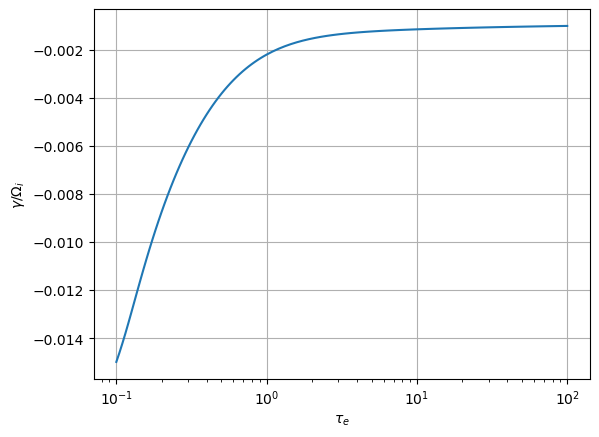

In [18]:
xkey = 'p2tau'
ykey = 'g'
xlabel = r"$\tau_e$"
ylabel = r"$\gamma / \Omega_i$"
ylim = []
xlim = []
root = roots[rootidx]

plot_root = False #will plot scatter point x,y = sweep[xkey],sweep['w'] for value at input kperp,kpar,omega. This is the origin of the sweep

flnm = 'figures/'+filetag+'/'+filetag+'dispreltotpower.png'
lp.plot_disp_rel(plumeinput, root, sweep, xkey, ykey, xlabel, ylabel, flnm=flnm, plot_root = plot_root, xlim = xlim, ylim = ylim)

## Sweep over two variables from selected root

In [19]:
var1key = 'kperp'
var2key = 'kpar'

var1min = 1
var1max = 10
var2min = 1
var2max = 10

stylenum1 = 0
stylenum2 = 0

inputflnm = inputfldr+'2varsweep'
outputname = '2varsweep'

sweep2d = lfpc.branch_2var_scan_from_root(plumeinput,stylenum1,stylenum2,var1key,var1min,var1max,var2key,var2min,var2max,root,inputflnm,outputname,verbose=False,outlog='outlog',nsamps=20)
    

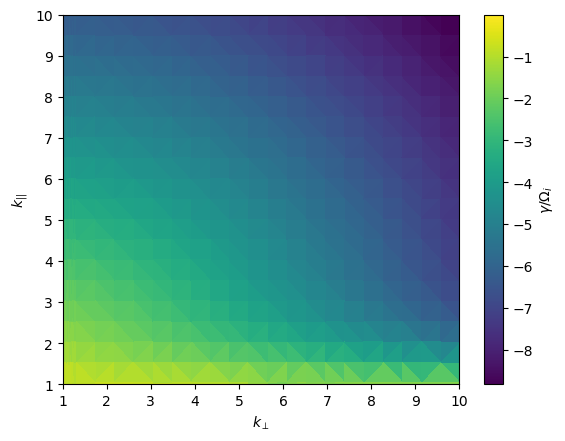

In [20]:
xkey = 'kperp'
ykey = 'kpar'
zkey = 'g'
xlim = [1,10]
ylim = [1,10]
xlabel = r'$k_{\perp}$'
ylabel = r'$k_{||}$'
zlabel = r'$\gamma/\Omega_{i}$'

importlib.reload(lp)
lp.sweep2dplot(sweep2d,xkey,ykey,zkey,xlabel,ylabel,zlabel,xlim=xlim,ylim=ylim,vmin=None,vmax=None)

In [21]:
importlib.reload(lfpc)
importlib.reload(lp)


var1key = 'betap'
var2key = 'alphS'

var1min = 0.5
var1max = 5
var2min = 0.5
var2max = 5

stylenum1 = 0
stylenum2 = 1

inputflnm = inputfldr+'2varsweep'
outputname = '2varsweep'

sweep2d_2 = lfpc.branch_2var_scan_from_root(plumeinput,stylenum1,stylenum2,var1key,var1min,var1max,var2key,var2min,var2max,root,inputflnm,outputname,verbose=False,outlog='outlog',nsamps=20)
    

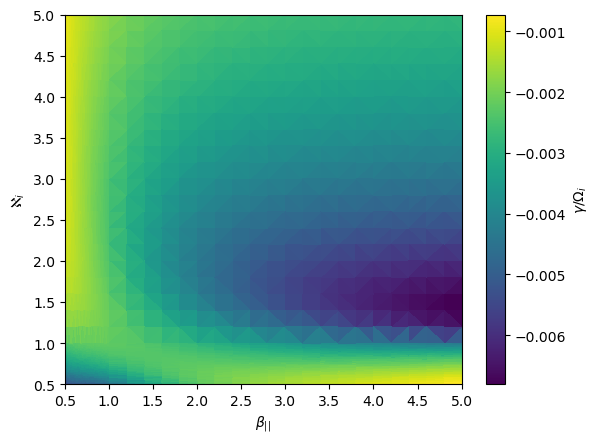

In [22]:
xkey = 'betap'
ykey = 'p1alph'
zkey = 'g'
xlim = [.5,5]
ylim = [.5,5]
xlabel = r'$\beta_{||}$'
ylabel = r'$\aleph_i$' #Tperp,i to Tpar,i ratio
zlabel = r'$\gamma/\Omega_{i}$'

importlib.reload(lp)
lp.sweep2dplot(sweep2d_2,xkey,ykey,zkey,xlabel,ylabel,zlabel,xlim=xlim,ylim=ylim,vmin=None,vmax=None)

## Predict FPC signature of selected root and fs1 in gyro coordinates

The following blocks of code will generate 8 figures in the 'figures' folder of the parallel correlation, perpendicular correlation, and real/imag component of fs1 for both species.

In [23]:
vperpmin = .0
vperpmax = 3
vparmin = -3
vparmax = 3
delv = .15
plumeinput.set_fpc(vperpmin,vperpmax,vparmin,vparmax,delv)

In [24]:
scan_type=0
scan_style=0
swi=0
swf=0
swlog=True
ns=0
nres=1
heating=True #While no sweep is performed here, we need to define these bools, (heating and eigen)
eigen=True
plumeinput.make_scan(scan_type,scan_style,swi,swf,swlog,ns,nres,heating,eigen)

In [25]:
importlib.reload(lfpc)

inputflnm = inputfldr+'fpc'
outputflnm = 'fpc'
cdataflnms = lfpc.compute_fpc_from_root(plumeinput,roots[rootidx],inputflnm,outputflnm)

mkdir data/howes2017
./plume.e input/howes2017/fpc.in >> outlog


mkdir: data/howes2017: File exists


In [26]:
#Files produced by above command
print(cdataflnms)

['data/howes2017/fpc.cpar.specie01.mode01', 'data/howes2017/fpc.cperp.specie01.mode01', 'data/howes2017/fpc.df1gyro.real.specie01.mode01', 'data/howes2017/fpc.df1gyro.imag.specie01.mode01', 'data/howes2017/fpc.cpar.specie02.mode01', 'data/howes2017/fpc.cperp.specie02.mode01', 'data/howes2017/fpc.df1gyro.real.specie02.mode01', 'data/howes2017/fpc.df1gyro.imag.specie02.mode01']


In [27]:
iondatacpar = lfpc.loadlinfpccepar(cdataflnms[0])
iondatacperp = lfpc.loadlinfpcceperp(cdataflnms[1])
iondatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[2],cdataflnms[3])
elecdatacpar = lfpc.loadlinfpccepar(cdataflnms[4])
elecdatacperp = lfpc.loadlinfpcceperp(cdataflnms[5])
elecdatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[6],cdataflnms[7])

In [28]:
cmd = 'mkdir figures/'+filetag
print(cmd)
os.system(cmd)

mkdir figures/howes2017


mkdir: figures/howes2017: File exists


256

Saving figure to figures folder!


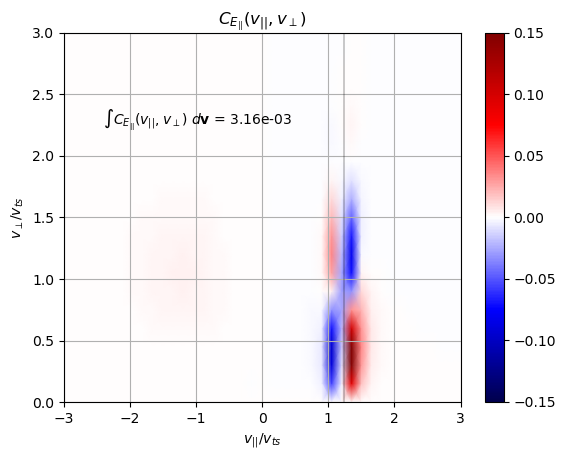

In [29]:
importlib.reload(lp)

lp.plotlinfpc_gyro(iondatacpar,filetag+'/'+filetag+'.png',plotresonant=True) #plotresonant attempts to calculate expected resonant velocity of landau damping and plots a vertical line there
                                                                          #as $\int_{-\infty}^{+\infty} C_E_{||} = j_{||}E_{||}$ it useful to consider this quantity

Saving figure to figures folder!


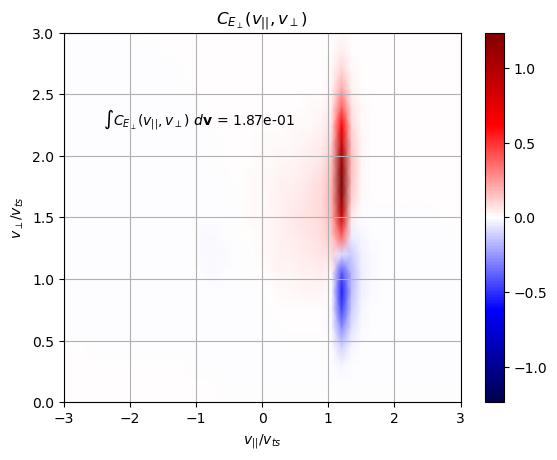

In [30]:
lp.plotlinfpc_gyro(iondatacperp,filetag+'/'+filetag+'cperp.png')

Saving figure to figures folder!


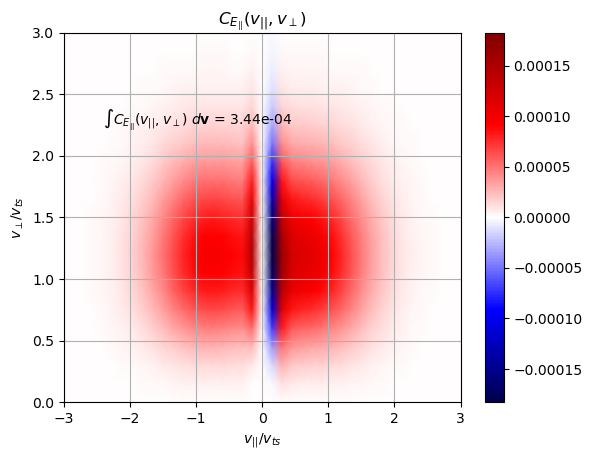

In [31]:
lp.plotlinfpc_gyro(elecdatacpar,filetag+'/'+filetag+'elec.png')

Saving figure to figures folder!


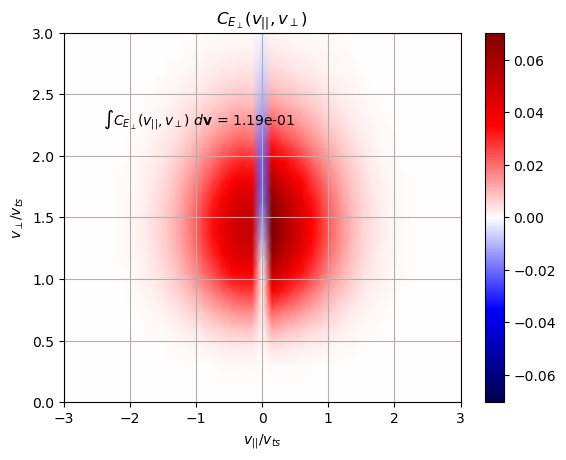

In [32]:
lp.plotlinfpc_gyro(elecdatacperp,filetag+'/'+filetag+'eleccperp.png')

plotting linear scale!
Saving figure to figures folder!


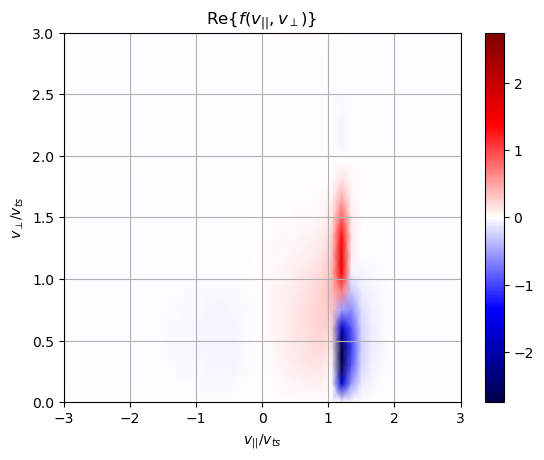

plotting linear scale!
Saving figure to figures folder!


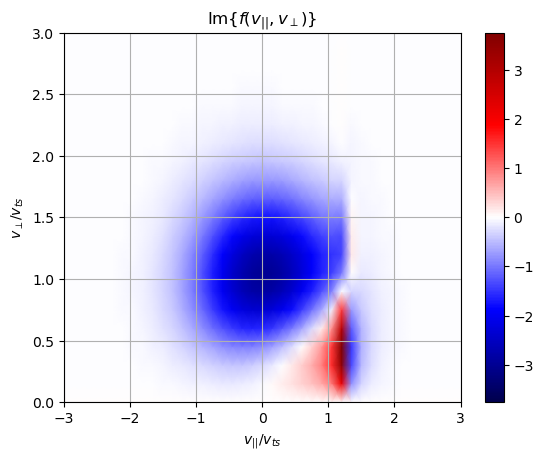

In [33]:
lp.plotlinfpc_gyro_dist(iondatarfs1,filetag+'/'+filetag+'ionrfs1.png','re_f')
lp.plotlinfpc_gyro_dist(iondatarfs1,filetag+'/'+filetag+'ionifs1.png','im_f')

plotting linear scale!
Saving figure to figures folder!


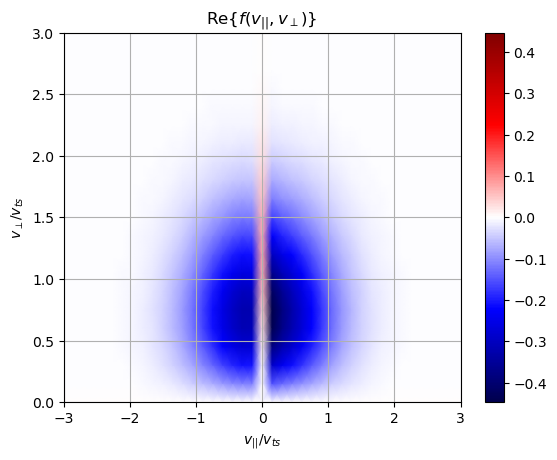

plotting linear scale!
Saving figure to figures folder!


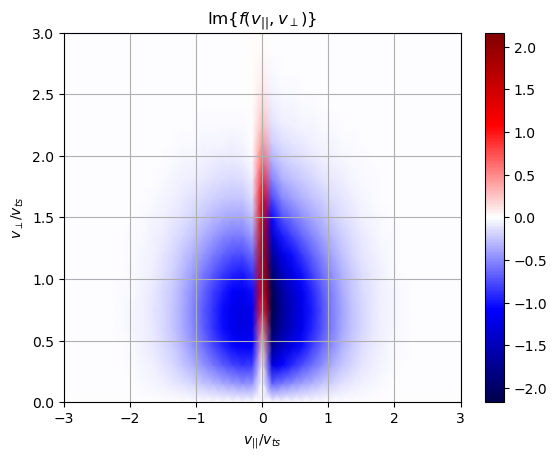

In [34]:
lp.plotlinfpc_gyro_dist(elecdatarfs1,filetag+'/'+filetag+'elecrfs1.png','re_f')
lp.plotlinfpc_gyro_dist(elecdatarfs1,filetag+'/'+filetag+'elecifs1.png','im_f')

## Predict FPC signature of selected root and fs1 in cartesian coordinates

mkdir data/howes2017
./plume.e input/howes2017/fpc.in >> outlog


mkdir: data/howes2017: File exists


Reading:  data/howes2017/fpc.cparcart.specie01.mode01


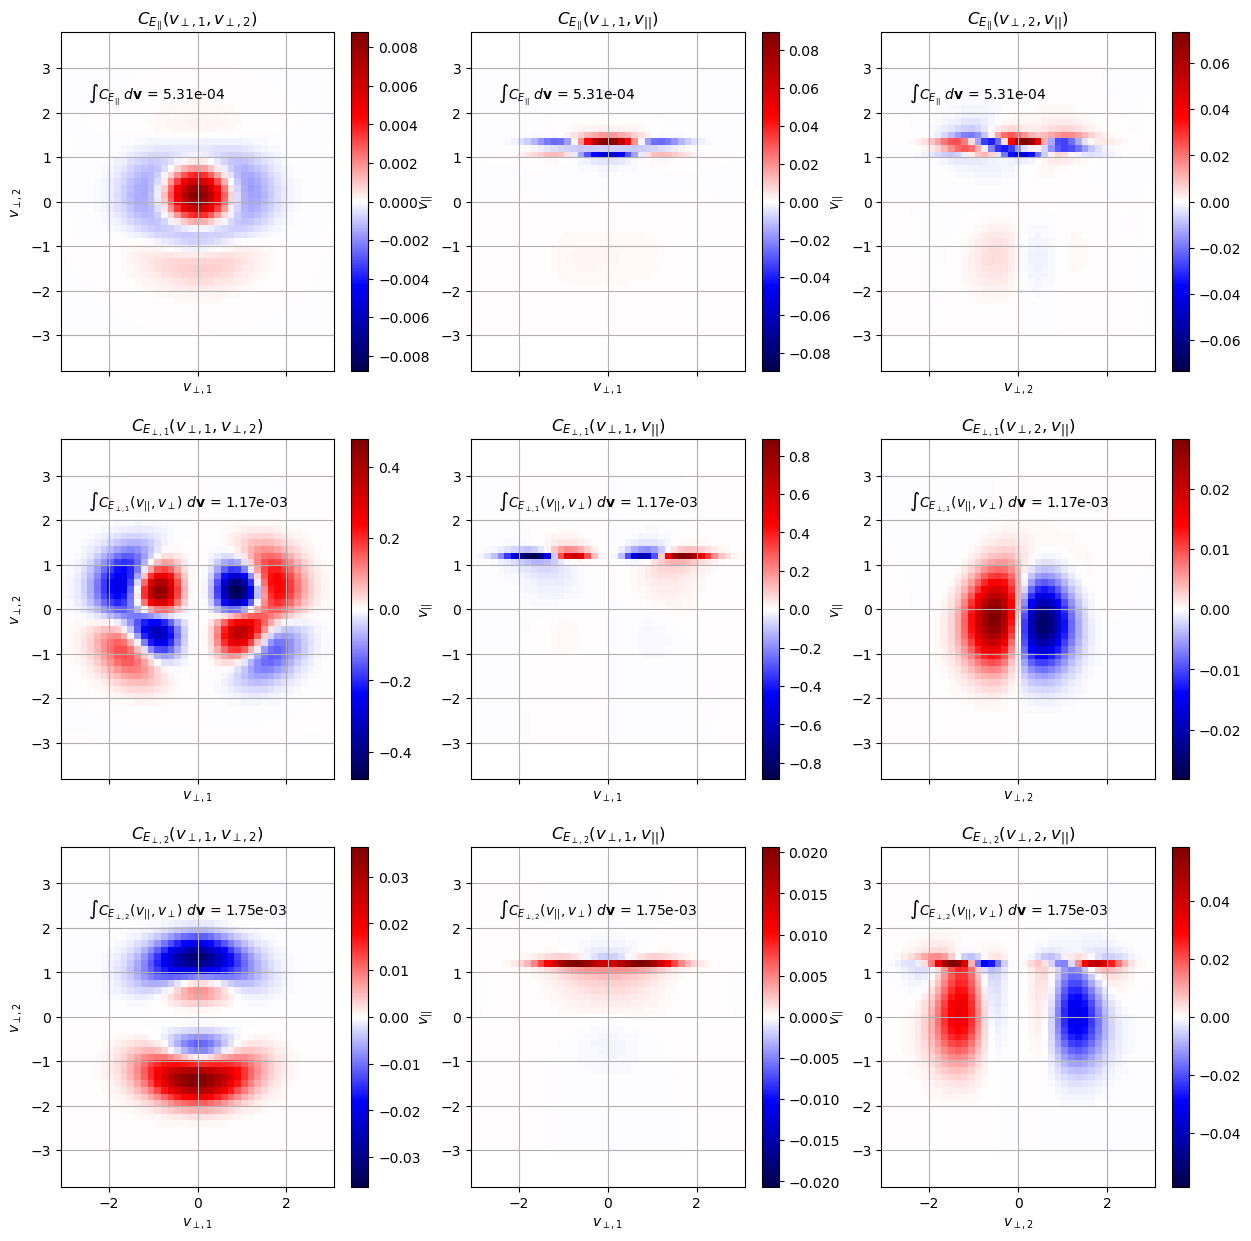

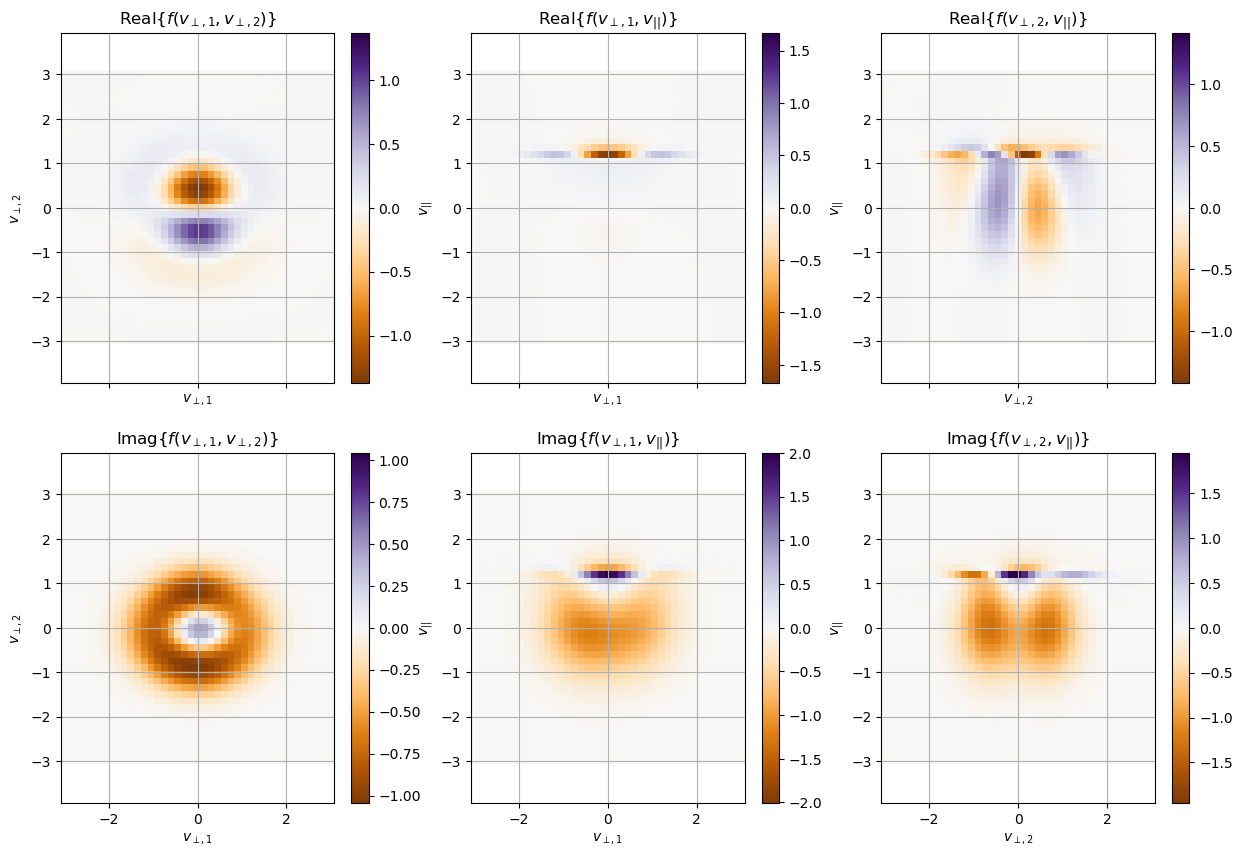

Reading:  data/howes2017/fpc.cparcart.specie02.mode01


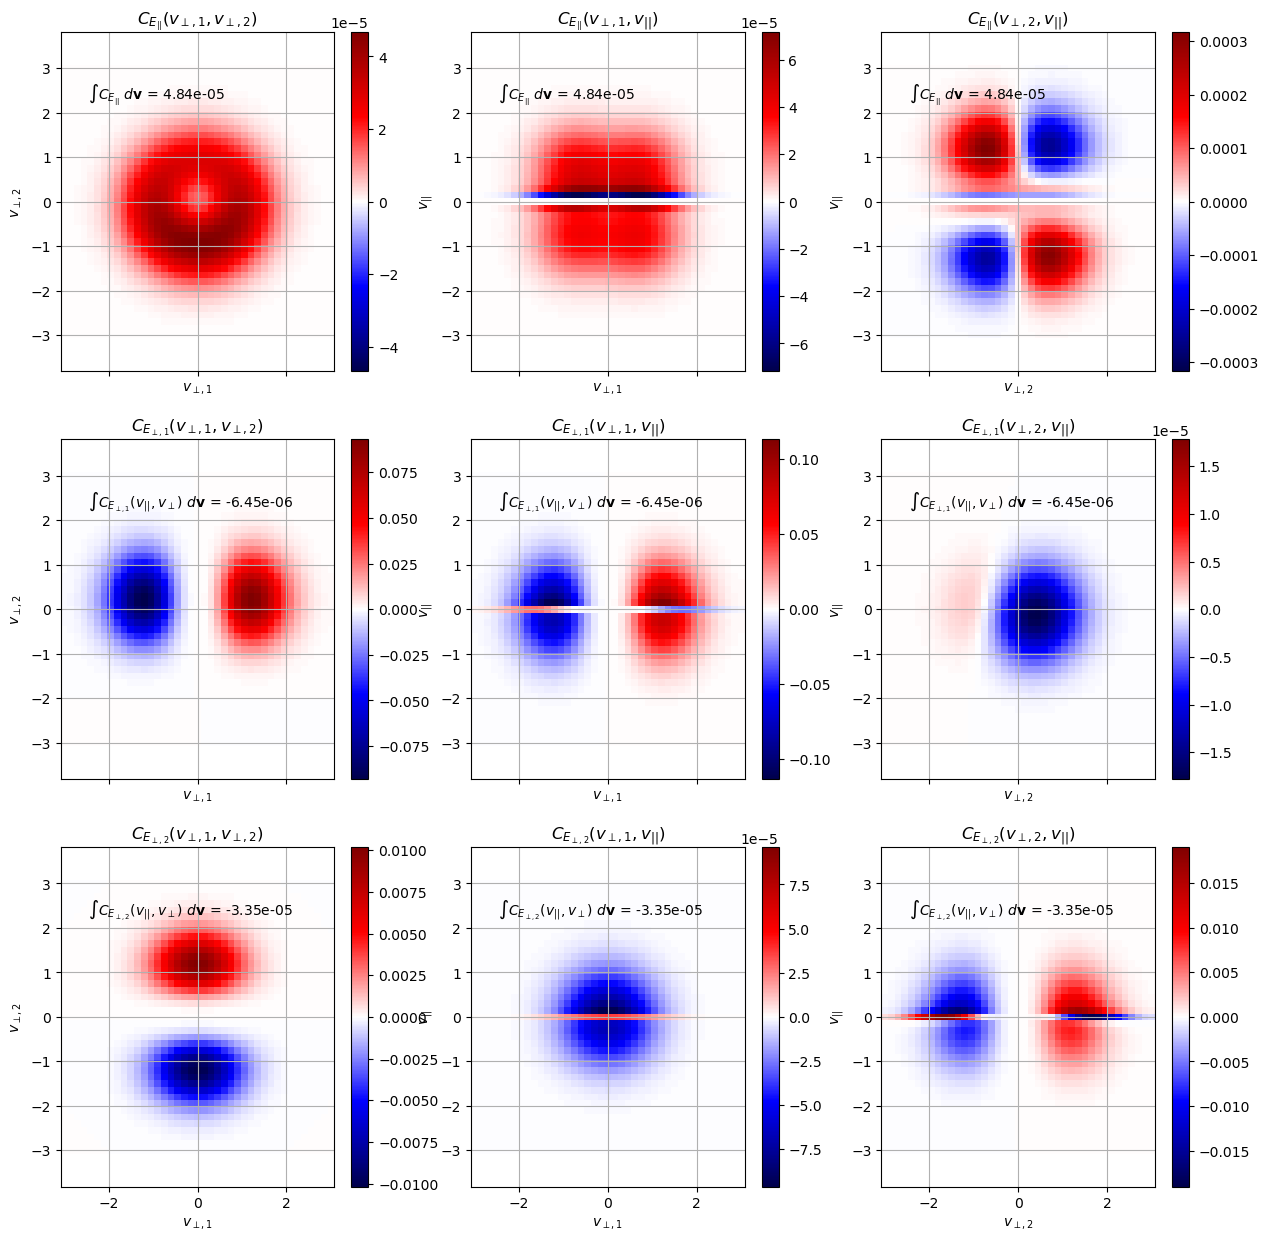

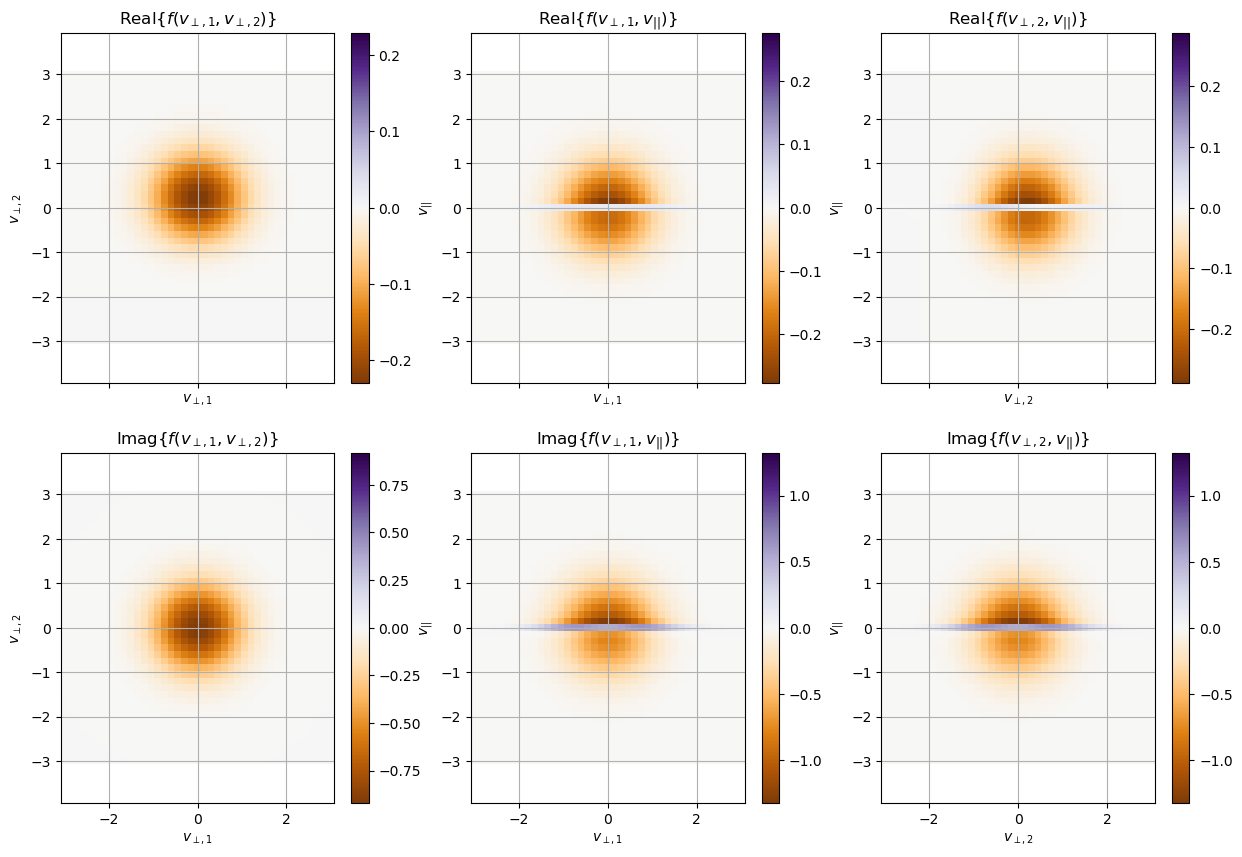

In [35]:
vperpmin = .05
vperpmax = 3 
vparmin = -3
vparmax = 3
vxmin = -3
vymin = -3
vzmin = -3
vxmax = 3
vymax = 3
vzmax = 3
delv = .15
plumeinput.set_fpc(delv=delv,vxmin=vxmin,vxmax=vxmax,vymin=vymin,vymax=vymax,vzmin=vzmin,vzmax=vzmax)


#if a change is made to the above libraries, one can either restart the notebook, 
#  or call these functions to load changes in library
import importlib
importlib.reload(lfpc)
importlib.reload(lp)

inputflnm = inputfldr+'fpc'
outputflnm = 'fpc'
cdataflnms = lfpc.compute_fpc_from_root(plumeinput,roots[rootidx],inputflnm,outputflnm,cart=True)

foldername = cdataflnms[0].split('/')
foldername = foldername[0]+'/'+foldername[1]+'/'

flnm = 'figures/'+filetag+'/'+filetag+'ionfpccart.png'
lp.plot_9pan_cart(foldername,outputflnm,flnm=flnm,specnum='01',computeEner=True)
flnm = 'figures/'+filetag+'/'+filetag+'ionfs1.png'
lp.plot_fs1_re_im_cart(foldername,outputflnm,flnm=flnm,specnum='01')

flnm = 'figures/'+filetag+'/'+filetag+'elecfpccart.png'
lp.plot_9pan_cart(foldername,outputflnm,flnm=flnm,specnum='02',computeEner=True)
flnm = 'figures/'+filetag+'/'+filetag+'elecfs1.png'
lp.plot_fs1_re_im_cart(foldername,outputflnm,flnm=flnm,specnum='02')

## Plot output
Plots made in this notebook can also be found in the figures folder.

## Print outlog

The wrapper outputs all statements from the program to the 'outlog' file. Note that output from new plume.e will be concatenated onto the end of the file. It is important that the user check this log for any warning or error messages!

In [36]:
#Let's check the output of all of our calculations to check for any warning messages!
#Note, output from each run is concatenated...

size = os.path.getsize('outlog')

if(size < 9999999):
    os.system('cat outlog')
else:
    print("Warning: outlog is large and is not displayed here. Please check the outlog file...")